## Smoothing 

(py3) Niki.Zadeh: /net2/nnz/grid_generation/workdir $ ../ocean_grid_generator.py -f tripolar_res4_areacorrected.nc -r 4 --south_cutoff_row 81


In [10]:
import imp  
import ocean_grid_generator as ogg
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np

Requesting Mercator grid with phi range: phi_s,phi_n= -66.85954724706843 64.0589597296948
   y*= [-727  673] nj= 1401
   Supergrid has an odd number of area cells!
   Fixing this by shifting the y_star[1] 
   y*= [-727  672] nj= 1400
   Generating Mercator grid with phi range: phi_s,phi_n= [-66.85954725  64.00422531]
   Equator is at j= 727
   number of js= 1400
MIDAS number of bipolar cap js=  479
New   number of bipolar cap js=  473
Generating bipolar grid bounded at latitude  64.0590671656
   number of js= 474
Last  lattitude of Mercator 64.004225313
First lattitude of Bipolar  64.0590671656
DM   0.0548418526513
DMB  0.0548418526513
DB   0.0548434097979
Generating regular lat-lon grid between latitudes  -78.0 -66.9087198534
   The number of j's is not even. Fixing this by cutting one row at south.
   generated regular lat-lon grid between latitudes  -77.9509235392 -66.9087198534
   number of js= 226
First lattitude of Mercator -66.8595472471
Last  lattitude of SO       -66.908719853

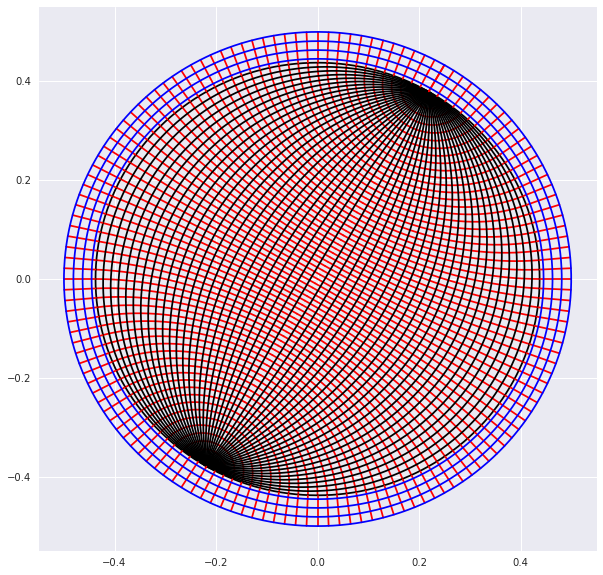

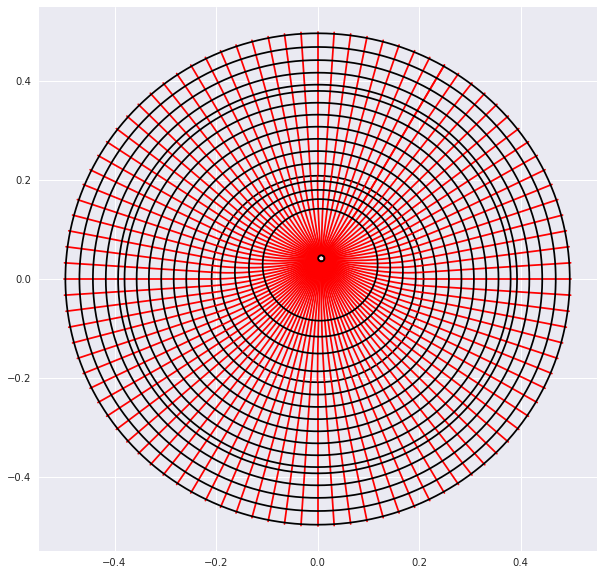

In [24]:

### Specify the grid properties
#Nominal grid resolution
refineR=4 # This is the inverse of the desired degrees of resolution (degree_resolution_inverse  )

#Mercator grid
#MIDAS has nominal starting latitude for Mercator grid = -65 for 1/4 degree, -70 for 1/2 degree
#MIDAS has nominal latitude range of Mercator grid     = 125 for 1/4 degree, 135 for 1/2 degree
#Instead we use the actual values used in MIDAS 1/8 degree grid
#Niki: Why? Make a concrete fool proof argument for this.
phi_s_Merc, phi_n_Merc = -66.85954724706843, 64.0589597296948

lat0_SO=-78.0 #Starting lattitude of Southern Ocean grid (Why?)

lon0=-300.    #Starting longitude (longitude of the Northern bipoles) (Why?)
lon_bp=lon0   #Starting longitude of the displaced pole(s) (Why?)

#The rest of the variables are derived from above or from geometry and need not be touched.
refineS=2   # Set to 2 for supergrid
lenlon=360  # global longitude range
Ni=refineR*refineS* lenlon #To get the desired resolution at the equator


imp.reload(ogg)  
#Generate the Mercator grid 
lamMerc,phiMerc = ogg.generate_mercator_grid(Ni,phi_s_Merc,phi_n_Merc,lon0,lenlon,ensure_nj_even=True)    
#The phi resolution in the last row of Mercator grid along the symmetry meridian
DeltaPhiMerc_so = phiMerc[ 1,Ni//4]-phiMerc[ 0,Ni//4]
DeltaPhiMerc_no = phiMerc[-1,Ni//4]-phiMerc[-2,Ni//4]

#Generate the Bipolar grid. 
lat0_bp = phiMerc[-1,Ni//4] + DeltaPhiMerc_no #Start from a lattitude to smooth out dy.

Nj_ncap=refineR* 120 - 1   #MIDAS has refineS*( 240 for 1/4 degree, 119 for 1/2 degree
print("MIDAS number of bipolar cap js= ", Nj_ncap)

Nj_ncap = int(0.5+(90.-lat0_bp)/DeltaPhiMerc_no) #Impose boundary condition for smooth dy
print("New   number of bipolar cap js= ", Nj_ncap)

lamBP,phiBP = ogg.generate_bipolar_cap_grid(Ni,Nj_ncap,lat0_bp,lon0,lenlon)

#ogg.plot_mesh_in_xyz(lamBP, phiBP, stride=20)

print("Last  lattitude of Mercator",phiMerc[-1,0])
print("First lattitude of Bipolar ",phiBP[0,0])
print("DM  ",phiMerc[-1,Ni//4]-phiMerc[-2,Ni//4])
print("DMB ",phiBP[0,Ni//4]-phiMerc[-1,Ni//4])
print("DB  ",phiBP[1,Ni//4]-phiBP[0,Ni//4])

#Generate the Southern Ocean grid
lat0_SO=-78.0
lenlat_SO = phiMerc[0,Ni//4] - DeltaPhiMerc_so - lat0_SO #Start from a lattitude to smooth out dy.
Nj_SO = int(0.5 + lenlat_SO/DeltaPhiMerc_so) #nearest integer
lamSO,phiSO = ogg.generate_latlon_grid(Ni,Nj_SO,lon0,lenlon,lat0_SO,lenlat_SO)

print("First lattitude of Mercator",phiMerc[0,0])
print("Last  lattitude of SO      ",phiSO[-1,0])
print("DM  ",phiMerc[1,Ni//4]-phiMerc[0,Ni//4])
print("DMSO",phiMerc[0,Ni//4]-phiSO[-1,Ni//4])
print("DSO ",phiSO[-1,Ni//4]-phiSO[-2,Ni//4])
print("DSO ",phiSO[1,Ni//4]-phiSO[0,Ni//4])


#Generate the southern cap grid
lon_dp=100.0   # longitude of the displaced pole 
r_dp =0.2
doughnut=0.0
deltaPhiSO = phiSO[1,Ni//4]-phiSO[0,Ni//4]
lat0_SC=phiSO[0,Ni//4]-deltaPhiSO
fullArc = lat0_SC+90.
halfArc = fullArc/2
#halfArc = lat0_SC - 0.5*(lat0_SC-90.)
nparts=8

Nj_scap=refineR*  40   #MIDAS has refineS*(  80 for 1/4 degree, ??? for 1/2 degree
print("MIDAS number of southern cap js= ", Nj_scap)

Nj_scap = int((nparts/(nparts-1))*halfArc/deltaPhiSO) #Impose boundary condition for smooth dy
print("new   number of southern cap js= ", Nj_scap)

lamc_DP,phic_DP = ogg.generate_displaced_pole_grid(Ni,Nj_scap,lon0,lenlon,lon_dp,r_dp,lat0_SC,doughnut,nparts)

print("First lattitude of SO ",phiSO[0,0])
print("Last  lattitude of DP ",phic_DP[-1,0])
print("DSO ",phiSO[1,Ni//4]-phiSO[0,Ni//4])
print("DSS ",phiSO[0,Ni//4]-phic_DP[-1,Ni//4])
print("DSC ",phic_DP[-1,Ni//4]-phic_DP[-2,Ni//4])
print("DSC ",phic_DP[1,Ni//4]-phic_DP[0,Ni//4])


#plot grids

plt.figure(figsize=(10,10))
ogg.plot_mesh_in_xyz(lamBP, phiBP, stride=20,newfig=False)
ogg.plot_mesh_in_xyz(lamMerc,phiMerc, phi_color='b', stride=20,lowerlat=60,newfig=False)

plt.figure(figsize=(10,10))
ogg.plot_mesh_in_xyz(lamSO,phiSO, stride=30,newfig=False)
ogg.plot_mesh_in_xyz(lamc_DP,phic_DP, stride=30,newfig=False)
ogg.plot_mesh_in_xyz(lamMerc,phiMerc, stride=30, upperlat=-60,newfig=False)


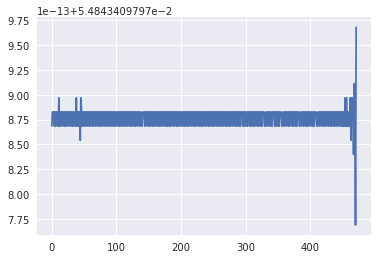

In [20]:
dyBP = np.roll(phiBP,shift=-1,axis=0) -phiBP
#print(dyBP[:,Ni//4])
plt.plot(dyBP[:-2,Ni//4]);